In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import os

<AxesSubplot:ylabel='Density'>

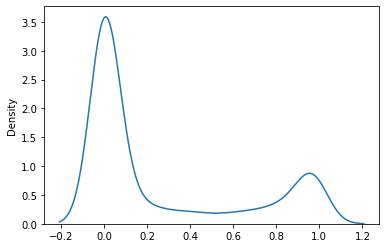

In [15]:
probs_for_eval = np.random.uniform(-1, 1, 4798) -0.5
golds_for_eval = np.floor(np.random.uniform(0, 1.01, 4798))
probs_for_eval += 0.5*golds_for_eval
probs_for_eval = np.exp(10*probs_for_eval)/(1+np.exp(10*probs_for_eval))
sns.kdeplot(probs_for_eval)

<AxesSubplot:xlabel='probs', ylabel='Density'>

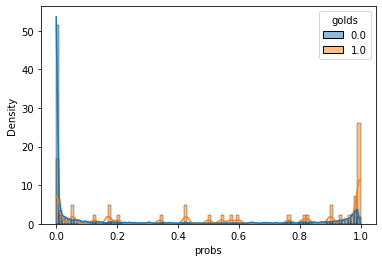

In [16]:
df = pd.DataFrame({"probs": probs_for_eval, "golds": golds_for_eval})
sns.histplot(
    data=df, x="probs", hue="golds", stat="density",
    common_norm=False, binwidth=0.01, kde=True, kde_kws={"bw_adjust":0.05})

In [17]:
df = df.sort_values(by='probs')
df['idx'] = range(df.shape[0])
df['idx'] *= -1

<AxesSubplot:xlabel='idx', ylabel='probs'>

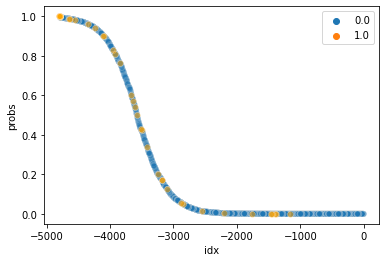

In [18]:
df = df.sort_values(by='golds')
df_pos = df.loc[df['golds']==1]
sns.scatterplot(data=df, x='idx', y='probs', hue='golds', alpha=0.1)
sns.scatterplot(data=df_pos, x='idx', y='probs', color='orange', alpha=0.5)

array([60, 36, 12,  6])

<AxesSubplot:xlabel='group', ylabel='probs'>

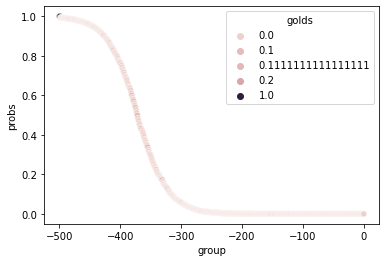

In [47]:
df['group'] = (df['idx']/df.idx.min()*(-100)).astype(int)
df['group'] = (df['idx']/df.idx.quantile(0.8)*(-100)).astype(int)
df_binned = df.groupby(by='group').agg({'probs':'mean', 'golds':'mean', 'idx':'max'})
sns.scatterplot(data=df_binned, x='group', y='probs', hue='golds')

<AxesSubplot:xlabel='probs', ylabel='Proportion'>

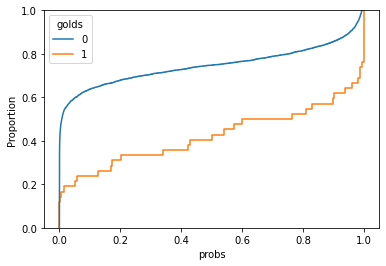

In [48]:
sns.ecdfplot(data=df, x='probs', hue='golds')

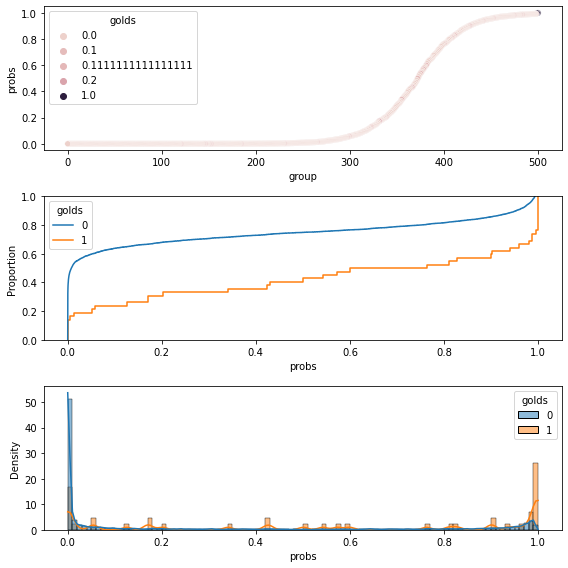

In [49]:
plt.subplots(3, 1, figsize=[8,8])
plt.subplot(3,1,1)
df_binned['group'] = abs(df_binned.index)
sns.scatterplot(data=df_binned, x='group', y='probs', hue='golds')
plt.subplot(3,1,2)
sns.ecdfplot(data=df, x='probs', hue='golds')
plt.subplot(3,1,3)
sns.histplot(
    data=df, x="probs", hue="golds", stat="density",
    common_norm=False, binwidth=0.01, kde=True, kde_kws={"bw_adjust":0.05}
)
plt.tight_layout()

In [50]:
# 2nd batch of plots (OR-ish)
from sklearn.metrics import confusion_matrix as cm
from collections import Counter
df['golds'] = df['golds'].astype(int)
df.head()

,probs,golds,idx,group
728,3.127472e-07,0,0,0
3511,1.732988e-01,0,-3186,-332
97,1.732793e-01,0,-3185,-331
3652,1.732397e-01,0,-3184,-331
1347,1.731777e-01,0,-3183,-331


In [51]:
def get_confusion_matrix(df_slice):
    ct = Counter(df_slice['golds'])
    tp = ct[1.0]
    fp = ct[0.0]
    return tp, fp

TOTAL_NUM_POS = df['golds'].sum()
TOTAL_NUM_NEG = df.shape[0] - TOTAL_NUM_POS

def get_metrics(df_slice):
    """
    | TP | FN |
    | FP | TN |
    """
    tp, fp = get_confusion_matrix(df_slice)
    fn = TOTAL_NUM_POS - tp
    tn = TOTAL_NUM_NEG - fp
    if fn + tn == 0:  
        res = {
            'tpr':1, 'precision':TOTAL_NUM_POS/(TOTAL_NUM_POS+TOTAL_NUM_NEG), 
            'relative_risk':np.nan, 'odds_ratio':np.nan
        }
        return pd.Series(res)

    tpr = tp/TOTAL_NUM_POS
    precision = tp/(tp+fp)
    relative_risk = precision/(fn/(fn+tn))
    if fp == 0: 
        odds_ratio = np.nan
    else:
        odds_ratio = (tp/fp)/(fn/tn)

    res = {
        'tpr':tpr, 'precision':precision, 
        'relative_risk':relative_risk, 'odds_ratio':odds_ratio
    }
    return pd.Series(res)

get_metrics(df)

tpr              1.000000
precision        0.008754
relative_risk         NaN
odds_ratio            NaN
dtype: float64

In [56]:
res_against_pos_patients = {}
res_against_all_patients = {}
for i in range(400, 500):
    df_slice = df[df['group']<=-i]
    mx = get_metrics(df_slice)
    res_against_pos_patients.update({df_slice['golds'].sum(): mx})
    res_against_all_patients.update({df_slice.shape[0]: mx})

res_against_pos_patients = pd.DataFrame(res_against_pos_patients).transpose()
res_against_all_patients = pd.DataFrame(res_against_all_patients).transpose()

In [77]:
res_df['precision'] / res_df['relative_risk']

960    0.005472
950    0.005717
941    0.005704
931    0.005689
922    0.005676
         ...   
48     0.006526
39     0.006514
29     0.006500
20     0.006488
10     0.006683
Length: 100, dtype: float64

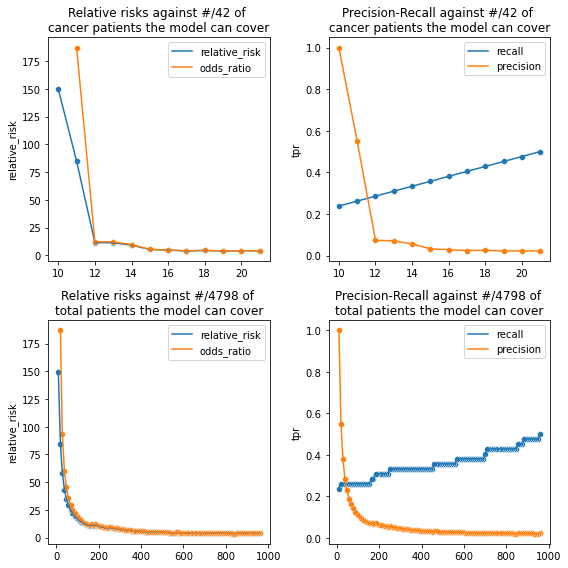

In [57]:
plt.subplots(figsize=[8,8])

res_df = res_against_pos_patients
plt.subplot(221)
sns.lineplot(data=res_df, x=res_df.index, y='relative_risk', label='relative_risk')
sns.lineplot(data=res_df, x=res_df.index, y='odds_ratio', label='odds_ratio')
sns.scatterplot(data=res_df, x=res_df.index, y='relative_risk')
sns.scatterplot(data=res_df, x=res_df.index, y='odds_ratio')
plt.title("Relative risks against #/{} of \ncancer patients the model can cover".format(TOTAL_NUM_POS))

plt.subplot(222)
sns.lineplot(data=res_df, x=res_df.index, y='tpr', label='recall')
sns.lineplot(data=res_df, x=res_df.index, y='precision', label='precision')
sns.scatterplot(data=res_df, x=res_df.index, y='tpr')
sns.scatterplot(data=res_df, x=res_df.index, y='precision')
plt.title("Precision-Recall against #/{} of \ncancer patients the model can cover".format(TOTAL_NUM_POS))

res_df = res_against_all_patients
plt.subplot(223)
sns.lineplot(data=res_df, x=res_df.index, y='relative_risk', label='relative_risk')
sns.lineplot(data=res_df, x=res_df.index, y='odds_ratio', label='odds_ratio')
sns.scatterplot(data=res_df, x=res_df.index, y='relative_risk')
sns.scatterplot(data=res_df, x=res_df.index, y='odds_ratio')
plt.title("Relative risks against #/{} of \ntotal patients the model can cover".format(
    TOTAL_NUM_POS + TOTAL_NUM_NEG
))

plt.subplot(224)
sns.lineplot(data=res_df, x=res_df.index, y='tpr', label='recall')
sns.lineplot(data=res_df, x=res_df.index, y='precision', label='precision')
sns.scatterplot(data=res_df, x=res_df.index, y='tpr')
sns.scatterplot(data=res_df, x=res_df.index, y='precision')
plt.title("Precision-Recall against #/{} of \ntotal patients the model can cover".format(
    TOTAL_NUM_POS + TOTAL_NUM_NEG
))
plt.tight_layout()

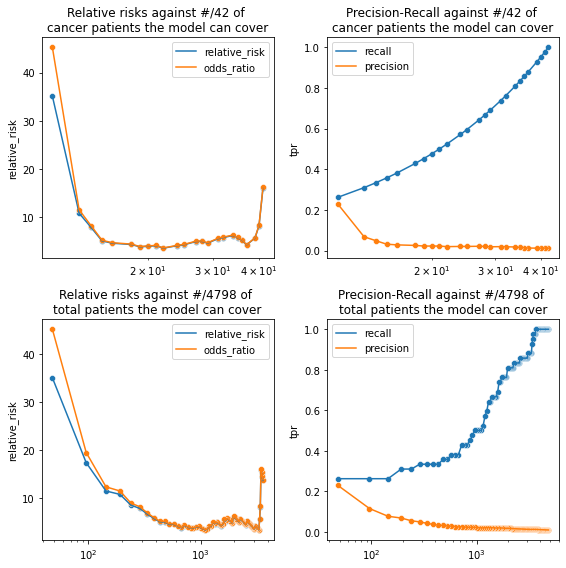

In [26]:
f, axs = plt.subplots(2,2,figsize=[8,8])

res_df = res_against_pos_patients
ax = plt.subplot(221)
sns.lineplot(data=res_df, x=res_df.index, y='relative_risk', label='relative_risk')
sns.lineplot(data=res_df, x=res_df.index, y='odds_ratio', label='odds_ratio')
sns.scatterplot(data=res_df, x=res_df.index, y='relative_risk')
sns.scatterplot(data=res_df, x=res_df.index, y='odds_ratio')
plt.title("Relative risks against #/{} of \ncancer patients the model can cover".format(TOTAL_NUM_POS))

plt.subplot(222)
sns.lineplot(data=res_df, x=res_df.index, y='tpr', label='recall')
sns.lineplot(data=res_df, x=res_df.index, y='precision', label='precision')
sns.scatterplot(data=res_df, x=res_df.index, y='tpr')
sns.scatterplot(data=res_df, x=res_df.index, y='precision')
plt.title("Precision-Recall against #/{} of \ncancer patients the model can cover".format(TOTAL_NUM_POS))

res_df = res_against_all_patients
plt.subplot(223)
sns.lineplot(data=res_df, x=res_df.index, y='relative_risk', label='relative_risk')
sns.lineplot(data=res_df, x=res_df.index, y='odds_ratio', label='odds_ratio')
sns.scatterplot(data=res_df, x=res_df.index, y='relative_risk')
sns.scatterplot(data=res_df, x=res_df.index, y='odds_ratio')
plt.title("Relative risks against #/{} of \ntotal patients the model can cover".format(
    TOTAL_NUM_POS + TOTAL_NUM_NEG
))

plt.subplot(224)
sns.lineplot(data=res_df, x=res_df.index, y='tpr', label='recall')
sns.lineplot(data=res_df, x=res_df.index, y='precision', label='precision')
sns.scatterplot(data=res_df, x=res_df.index, y='tpr')
sns.scatterplot(data=res_df, x=res_df.index, y='precision')
plt.title("Precision-Recall against #/{} of \ntotal patients the model can cover".format(
    TOTAL_NUM_POS + TOTAL_NUM_NEG
))
[a.set(xscale='log') for a in axs.flatten()]
f.tight_layout()